In [1]:
!pip install opendatasets
!pip install mediapipe
!pip install tensorflow

Saving File1.png to File1 (1).png
Saving File2.png to File2 (2).png
Saving File3.png to File3 (2).png
✅ 3 image(s) uploaded.

🔹 Processing: File1 (1).png
✅ Pose landmarks detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
🧘 Predicted Pose: Phalakasana


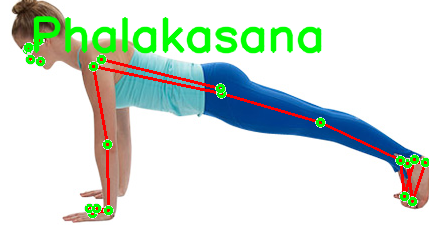

🔹 Processing: File2 (2).png
✅ Pose landmarks detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
🧘 Predicted Pose: Phalakasana


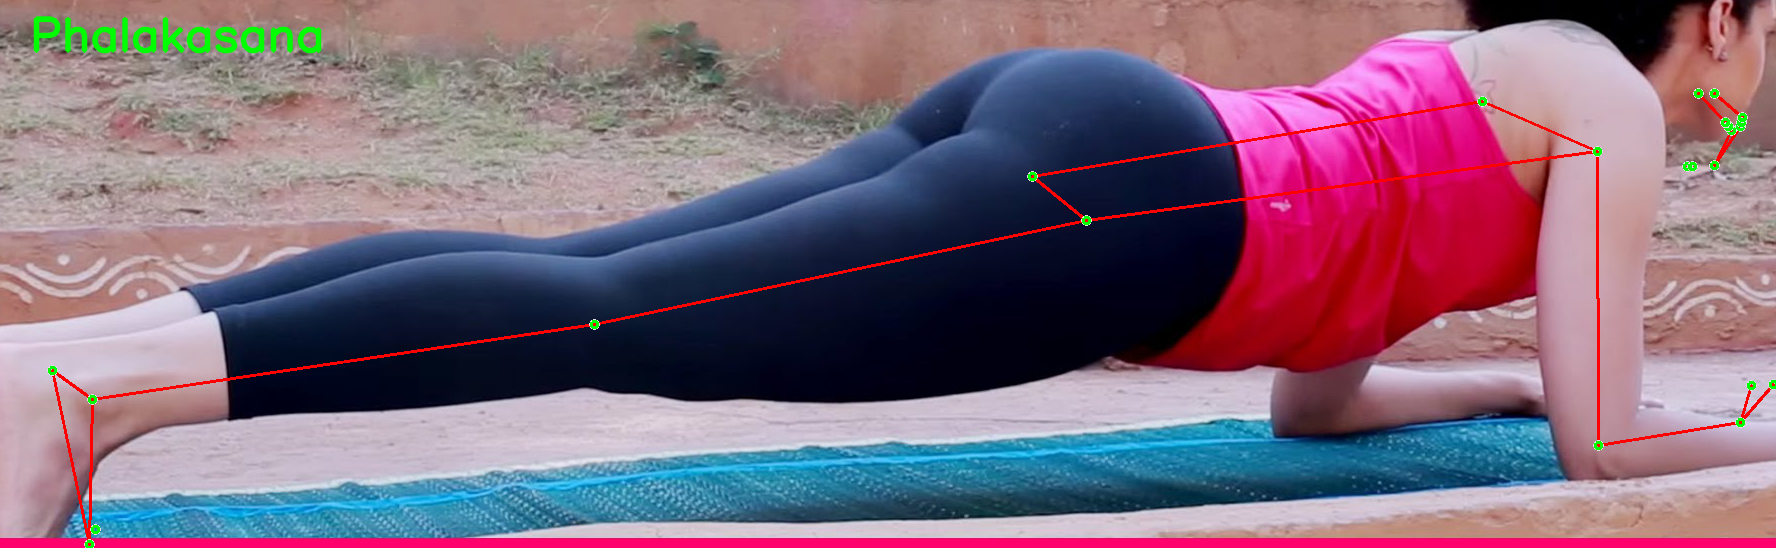

🔹 Processing: File3 (2).png
✅ Pose landmarks detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
🧘 Predicted Pose: Phalakasana


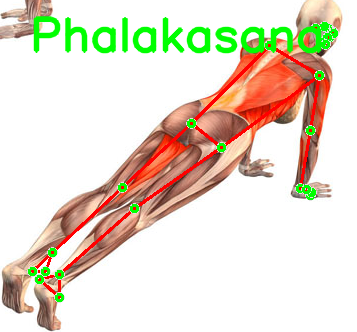

In [4]:
import numpy as np
import mediapipe as mp

mp_pose = mp.solutions.pose

def calculate_angle(a, b, c):
    """Calculate the angle between three points."""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))
    return angle

def calculate_distance(a, b):
    """Calculate the Euclidean distance between two points."""
    return np.linalg.norm(np.array(a) - np.array(b))

def extract_pose_features(landmarks):
    """Extract angles and distances from given pose landmarks."""
    # Define all key landmarks
    def L(p):  # shorthand
        return [
            landmarks[p].x,
            landmarks[p].y,
            landmarks[p].z
        ]

    A11, A12 = L(mp_pose.PoseLandmark.LEFT_SHOULDER), L(mp_pose.PoseLandmark.RIGHT_SHOULDER)
    A13, A14 = L(mp_pose.PoseLandmark.LEFT_ELBOW), L(mp_pose.PoseLandmark.RIGHT_ELBOW)
    A15, A16 = L(mp_pose.PoseLandmark.LEFT_WRIST), L(mp_pose.PoseLandmark.RIGHT_WRIST)
    A17, A18 = L(mp_pose.PoseLandmark.LEFT_PINKY), L(mp_pose.PoseLandmark.RIGHT_PINKY)
    A19, A20 = L(mp_pose.PoseLandmark.LEFT_INDEX), L(mp_pose.PoseLandmark.RIGHT_INDEX)
    A21, A22 = L(mp_pose.PoseLandmark.LEFT_THUMB), L(mp_pose.PoseLandmark.RIGHT_THUMB)
    A23, A24 = L(mp_pose.PoseLandmark.LEFT_HIP), L(mp_pose.PoseLandmark.RIGHT_HIP)
    A25, A26 = L(mp_pose.PoseLandmark.LEFT_KNEE), L(mp_pose.PoseLandmark.RIGHT_KNEE)
    A27, A28 = L(mp_pose.PoseLandmark.LEFT_ANKLE), L(mp_pose.PoseLandmark.RIGHT_ANKLE)
    A29, A30 = L(mp_pose.PoseLandmark.LEFT_HEEL), L(mp_pose.PoseLandmark.RIGHT_HEEL)
    A31, A32 = L(mp_pose.PoseLandmark.LEFT_FOOT_INDEX), L(mp_pose.PoseLandmark.RIGHT_FOOT_INDEX)

    # ---- Angles ----
    angles = [
        calculate_angle(A14, A12, A24),
        calculate_angle(A14, A12, A11),
        calculate_angle(A13, A11, A23),
        calculate_angle(A12, A11, A13),
        calculate_angle(A16, A14, A12),
        calculate_angle(A15, A13, A11),
        calculate_angle(A12, A24, A26),
        calculate_angle(A11, A23, A25),
        calculate_angle(A28, A26, A24),
        calculate_angle(A23, A25, A27),
        calculate_angle(A32, A28, A26),
        calculate_angle(A31, A27, A25),
        calculate_angle(A22, A16, A18),
        calculate_angle(A21, A15, A17)
    ]

    # ---- Distances ----
    dist_data = [
        calculate_distance(A16, A15),
        calculate_distance(A27, A28),
        calculate_distance(A16, A28),
        calculate_distance(A27, A15),
        calculate_distance(A16, A27),
        calculate_distance(A28, A15),
        calculate_distance(A12, A26),
        calculate_distance(A11, A25),
        calculate_distance(A11, A16),
        calculate_distance(A12, A15)
    ]

    # Combine all features into one list
    features = angles + dist_data
    return np.array(features, dtype=np.float32)


import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import joblib
import math
from google.colab.patches import cv2_imshow


# ---------- Load trained model and scaler ----------
model = load_model("pose_classification_model.h5")
scaler = joblib.load("pose_scaler.pkl")   # must be same scaler used in training

# ---------- Mediapipe setup ----------
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)


# ---------- Load and process image ----------
from google.colab import files

uploaded = files.upload()  # upload multiple images at once
print(f"✅ {len(uploaded)} image(s) uploaded.\n")

for img_path in uploaded.keys():
    print(f"🔹 Processing: {img_path}")
    image = cv2.imread(img_path)



    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if not results.pose_landmarks:
        print("❌ No pose detected in the image. Try a clearer or full-body image.")
    else:
        print("✅ Pose landmarks detected.")

        # Draw pose landmarks
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=3),
            mp_drawing.DrawingSpec(color=(0,0,255), thickness=2)
        )

        # Extract and scale features
        landmarks = results.pose_landmarks.landmark
        X = extract_pose_features(landmarks)
        X_scaled = scaler.transform([X])  # apply the same scaling as training

        # Predict pose
        prediction = model.predict(X_scaled)
        pose_index = np.argmax(prediction)





    pose_labels = {
    0: 'Virabhadrasana Three',
    1: 'Phalakasana',
    2: 'Bitilasana',
    3: 'Uttanasana',
    4: 'Vrksasana',
    5: 'Adho Mukha Svanasana',
    6: 'Padmasana',
    7: 'Virabhadrasana One',
    8: 'Garudasana',
    9: 'Salamba Sarvangasana',
    10: 'Bakasana',
    11: 'Utkatasana',
    12: 'Utthita Parsvakonasana',
    13: 'Anjaneyasana',
    14: 'Ardha Matsyendrasana',
    15: 'Halasana',
    16: 'Baddha Konasana',
    17: 'Utthita Hasta Padangusthasana',
    18: 'Balasana',
    19: 'Vasisthasana',
    20: 'Urdhva Mukha Svsnssana',
    21: 'Ustrasana',
    22: 'Camatkarasana',
    23: 'Setu Bandha Sarvangasana',
    24: 'Malasana'
}




    predicted_label = pose_labels[pose_index]
    print(f"🧘 Predicted Pose: {predicted_label}")

    # Display on image
    cv2.putText(image, f"{predicted_label}", (30, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 3, cv2.LINE_AA)

    # Show image
    cv2_imshow(image)

